<font size="4">**1. Importing Libraries**</font>

In [2]:
import os
import rasterio
import numpy as np
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

<font size="4">**2. Loading the Data**</font>

In [5]:
#path to the folder containing .tif files
tif_folder = "./Downloads/Rainfall/"

#list all .tif files
tif_files = sorted([os.path.join(tif_folder, f) for f in os.listdir(tif_folder) if f.endswith(".tif")])

print(f"Found {len(tif_files)} .tif files.")

Found 526 .tif files.


<font size="4">**3. Validating and Identifying Corrupted Files**</font>

This section validates the list of TIFF files and identifies corrupted files. It uses the rasterio library to attempt reading the first band of each file in the tif_files list. If the file is successfully opened and read without raising an exception, it is considered valid and appended to the valid_files list. Conversely, if an exception occurs during the attempt to open or read the file, it is deemed corrupted, and its name, along with the associated error, is printed for reference and added to the corrupted_files list. This ensures that only usable files proceed for further processing while providing a log of issues for troubleshooting.

At the end, the total counts of valid and corrupted files are printed. 

In [9]:
valid_files = []
corrupted_files = []

for file in tif_files:
    try:
        with rasterio.open(file) as src:
            src.read(1)  # Attempt to read the first band
        valid_files.append(file)
    except Exception as e:
        print(f"Corrupted file: {file} | Error: {e}")
        corrupted_files.append(file)

print(f"Valid files: {len(valid_files)}")
print(f"Corrupted files: {len(corrupted_files)}")

Valid files: 526
Corrupted files: 0


<font size="4">**4. Visualizing the Africa Shapefile**</font>

This section loads and visualizes a shapefile of Africa's geographic boundaries. Using the geopandas library, the shapefile located at the specified path is read into a GeoDataFrame named africa_shape. This data structure facilitates the manipulation and visualization of geographic data, making it suitable for mapping and spatial analysis tasks.

The plot() method of the GeoDataFrame is used to render the geographic boundary of Africa. This approach provides an initial inspection of the shapefile, to confirm the accuracy and completeness of the geographic data before further processing or analysis.

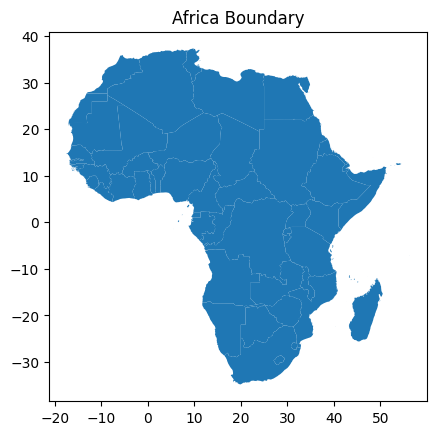

In [12]:
africa_shapefile = "./Downloads/Africa/Africa.shp"
africa_shape = gpd.read_file(africa_shapefile)

#visualize the shapefile
africa_shape.plot()
plt.title("Africa Boundary")
plt.show()

<font size="4">**5. Cropping Files to Africa's Boundary**</font>

This section processes valid TIFF files by cropping their content to align with Africa's geographic boundaries. A folder named cropped is created to store the cropped files. For each file in the valid_files list, it is opened using rasterio, and the mask function is applied. This function uses the geometry of the Africa shapefile to crop the raster data, retaining only the portion that intersects with the specified boundary. The spatial transformation and metadata are updated to reflect the cropped dimensions.

The cropped raster data is then saved to the cropped folder with its original filename preserved. The updated metadata ensures that the output files are accurate and maintain compatibility for further geospatial analysis. This process ensures that only the relevant portions of the raster data, confined to Africa's boundary, are retained and organized efficiently for subsequent tasks.

In [15]:
cropped_folder = "./Downloads/cropped"
os.makedirs(cropped_folder, exist_ok=True)

for file in valid_files:
    with rasterio.open(file) as src:
        #crop the data
        cropped, transform = mask(src, africa_shape.geometry, crop=True)
        meta = src.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": cropped.shape[1],
            "width": cropped.shape[2],
            "transform": transform
        })
        #save the cropped file
        cropped_file = os.path.join(cropped_folder, os.path.basename(file))
        with rasterio.open(cropped_file, "w", **meta) as dst:
            dst.write(cropped)

<font size="4">**6. Resampling Cropped Files**</font>

This section resamples files from the cropped folder to a specified spatial resolution and saves the results in a new folder called resampled. The target resolution is set as (0.1, 0.1) degrees, representing approximately 10 km spatial resolution. For each raster file in the cropped folder, the script adjusts the dimensions of the data to match the target resolution using bilinear interpolation, which ensures smooth resampling by averaging pixel values.

The metadata of each file is updated to reflect the new height, width, and transformation parameters corresponding to the resampled resolution. The resampled raster is then written to the resampled folder while preserving the original file structure. This process ensures that all raster files have a uniform resolution, making them suitable for consistent analysis and integration into larger geospatial workflows.

In [22]:
resampled_folder = "./Downloads/resampled"
os.makedirs(resampled_folder, exist_ok=True)

target_resolution = (0.1, 0.1)  # Example: 0.1 degrees (approx 10 km)

for file in os.listdir(cropped_folder):
    with rasterio.open(os.path.join(cropped_folder, file)) as src:
        data = src.read(
            out_shape=(
                src.count,
                int(src.height * target_resolution[1] / src.res[1]),
                int(src.width * target_resolution[0] / src.res[0])
            ),
            resampling=rasterio.enums.Resampling.bilinear
        )
        meta = src.meta.copy()
        meta.update({
            "height": data.shape[1],
            "width": data.shape[2],
            "transform": src.transform
        })
        resampled_file = os.path.join(resampled_folder, file)
        with rasterio.open(resampled_file, "w", **meta) as dst:
            dst.write(data)

<font size="4">**7. Reprojecting Files to a Target CRS**</font>

This section reprojects files in the resampled folder to a target coordinate reference system (CRS), specifically WGS84 Latitude/Longitude (EPSG:4326), and saves the reprojected files in a new folder called reprojected. The code calculates the transformation, width, and height required for the new CRS using the calculate_default_transform function from rasterio.warp. This ensures the raster data is correctly aligned with the geographic coordinates of the target CRS. Metadata for each raster file is updated to reflect the new spatial reference, including the CRS, transformation matrix, and dimensions.

The reprojected raster data is written to the reprojected folder using the nearest-neighbor resampling method, which assigns the value of the nearest source pixel to each target pixel. This method is computationally efficient and preserves the integrity of categorical data, if present. The script iterates over all bands in each raster file to ensure that multi-band data is fully reprojected. This reprojecting process standardizes all raster data to a consistent geographic reference, facilitating compatibility with other datasets and enabling accurate spatial analyses.

In [25]:
reprojected_folder = "./Downloads/reprojected"
os.makedirs(reprojected_folder, exist_ok=True)

target_crs = "EPSG:4326"  # WGS84 Latitude/Longitude

for file in os.listdir(resampled_folder):
    with rasterio.open(os.path.join(resampled_folder, file)) as src:
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        meta = src.meta.copy()
        meta.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height
        })
        reprojected_file = os.path.join(reprojected_folder, file)
        with rasterio.open(reprojected_file, "w", **meta) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=rasterio.enums.Resampling.nearest
                )